Step 0, Loss: -1.298832654953003, Predicted label: German Shepherd Dog
Step 50, Loss: -17.154922485351562, Predicted label: spoonbill
Step 100, Loss: -28.026430130004883, Predicted label: spoonbill
Step 150, Loss: -34.10744094848633, Predicted label: spoonbill
Step 200, Loss: -36.87649917602539, Predicted label: spoonbill
Step 250, Loss: -38.9434928894043, Predicted label: spoonbill
Step 300, Loss: -40.712493896484375, Predicted label: spoonbill
Step 350, Loss: -41.96601104736328, Predicted label: spoonbill
Step 400, Loss: -42.9875602722168, Predicted label: spoonbill
Step 450, Loss: -43.64072036743164, Predicted label: spoonbill


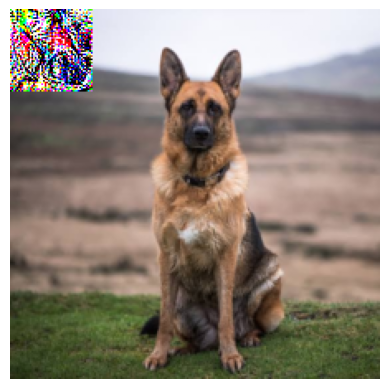

Predicted label after placing patch: spoonbill


In [13]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import urllib.request
import matplotlib.pyplot as plt
import numpy as np

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()

# Download ImageNet class labels
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
with urllib.request.urlopen(url) as response:
    labels = json.loads(response.read().decode())

# Define transformation for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load an example image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Overlay patch onto image without modifying the original image
def apply_patch_direct(image, patch, location):
    patched_image = image.clone()
    h, w = patch.shape[1:3]
    patched_image[:, :, location[0]:location[0]+h, location[1]:location[1]+w] = patch
    return patched_image

# Visualize the patched image
def visualize_image(image_tensor):
    image_np = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    plt.imshow(np.clip(image_np, 0, 1))
    plt.axis('off')
    plt.show()

# Adversarial patch training loop
def train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05):
    image = load_image(image_path)
    
    # Initialize random patch with the required size
    patch = torch.rand((3, *patch_size), requires_grad=True)
    optimizer = optim.Adam([patch], lr=lr)

    for step in range(num_steps):
        optimizer.zero_grad()
        
        # Apply patch directly without altering the base image
        patched_image = apply_patch_direct(image, patch, (0, 0))  # Place at the top-left corner
        
        # Forward pass through the model
        output = model(patched_image)
        
        # Calculate loss to maximize the target class probability
        loss = -output[0][target_class]
        loss.backward()
        
        # Update the patch
        optimizer.step()
        
        # Print training progress every 50 steps
        if step % 50 == 0:
            _, predicted_idx = torch.max(output, 1)
            predicted_label = labels[predicted_idx.item()]
            print(f"Step {step}, Loss: {loss.item()}, Predicted label: {predicted_label}")

    return patch

# Define the target class and train the patch on an example image
target_class = 129  # Replace with your desired target class index
image_path = "german_shepard_dog.jpeg"  # Replace with the path to your image 235
trained_patch = train_patch(image_path, target_class, patch_size=(50, 50), num_steps=500, lr=0.05)

# Save the trained adversarial patch
torch.save(trained_patch, "adversarial_patch_direct.pt")

# Load image and apply the adversarial patch for evaluation
image = load_image(image_path)

patched_image = apply_patch_direct(image, trained_patch, (0, 0))  # Place the patch in the same position used during training

# Visualize the patched image
visualize_image(patched_image)

# Classify the patched image
output = model(patched_image)
_, predicted_idx = torch.max(output, 1)
predicted_label = labels[predicted_idx.item()]

print(f"Predicted label after placing patch: {predicted_label}")


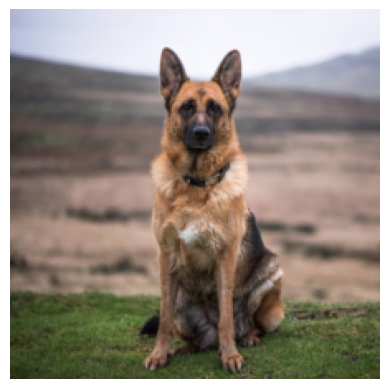

In [14]:
visualize_image(image)